<a href="https://colab.research.google.com/github/Simplar/Effect-of-temporal-window-on-HR-estimation/blob/master/RR_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is designed to support CVPM-2020 paper of CVPR Workshops, "Remote Photoplethysmography: Rarely Considered Factors"
Author: Mikhail Kopeliovich, kop@km.ru
If you use this code in your project, please, cite the paper:


In [0]:
# main imports
import tempfile
import os
import numpy as np
import pandas as pd
import glob

# Download and parsing

In [3]:
# Download subset of Fantasia database
# Dataset description: https://archive.physionet.org/physiobank/database/fantasia/subset/
fantasia_link = 'https://www.physionet.org/physiobank/database/fantasia/subset/heartbeat.tar'
tar_path = tempfile.gettempdir() + '/' + 'heartbeat.tar'
dir_subset = '/content/fantasia_subset/'  # note: Place your path to dataset directory here
DIR_RR = dir_subset + 'heartbeat/'
# download dataset to tmp folder
!wget {fantasia_link} -O {tar_path}
# extract archive
os.makedirs(dir_subset, exist_ok=True)
!tar -xf {tar_path} --directory {dir_subset}

--2020-04-12 17:30:20--  https://www.physionet.org/physiobank/database/fantasia/subset/heartbeat.tar
Resolving www.physionet.org (www.physionet.org)... 18.13.52.205
Connecting to www.physionet.org (www.physionet.org)|18.13.52.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 419840 (410K) [text/plain]
Saving to: ‘/tmp/heartbeat.tar’

/tmp/heartbeat.tar  100%[===================>] 410.00K  --.-KB/s    in 0.1s    

2020-04-12 17:30:21 (3.04 MB/s) - ‘/tmp/heartbeat.tar’ saved [419840/419840]



In [0]:
# parse txt
data_rr = []
filepath_txt = glob.glob(DIR_RR + '*.txt')
for filepath in filepath_txt:
  rr = np.loadtxt(filepath)
  basename = os.path.splitext(os.path.basename(filepath))[0]
  data_rr.append(rr)
time_rr = [np.vstack([np.cumsum(rr), rr]) for rr in data_rr]

# Calculation of differences (errors) between different time intervals

In [0]:
def rrs_for_range(subj_rr, t_start, t_length):
  return subj_rr[1][np.where( np.logical_and(subj_rr[0]>t_start, subj_rr[0]<t_start+t_length) )[0]]

def get_mean_rrs(subj_rr, t_start_big, int_big, int_small, step_small, rrs_big):
  if int_small == 0:
    return rrs_big
  rrs = [rrs_for_range(subj_rr, t_start_small, int_small).mean()
         for t_start_small in range(t_start_big, t_start_big + int_big - int_small, step_small)]
  return np.asarray(rrs)

In [0]:
# Compute errors between each pair of intervals in bpm (beats per minute)
step_small = 5
intervals = list(range(60,-1,-step_small)) #[60, 30, 10, 5, 0]
errs = [ [ [] for i in range(len(intervals))] for j in range(len(intervals)) ]

for subj_rr in time_rr:
  for idx_big, int_big in enumerate(intervals[:-1]):
    for t_start_big in range(0, int(subj_rr[0,-1])-int_big, int_big):
      rrs_big = rrs_for_range(subj_rr, t_start_big, int_big)
      hr_big = 1.0 / rrs_big.mean()
      for idx_small, int_small in enumerate(intervals[idx_big+1:], idx_big+1):
        rrs_mean_small = get_mean_rrs(subj_rr=subj_rr, t_start_big=t_start_big, int_big=int_big, int_small=int_small, step_small=step_small, rrs_big=rrs_big)
        hrs_small = 1.0 / rrs_mean_small
        err_nAE = np.abs(hrs_small - hr_big) / hr_big
        errs[idx_big][idx_small].extend( err_nAE )      
errs_mean = [ [np.mean(eee) if len(eee)>0 else np.NaN for eee in row] for row in errs ]
errs_std = [ [np.std(eee) if len(eee)>0 else np.NaN  for eee in row] for row in errs ]

In [0]:
df = pd.DataFrame(errs_mean)
intervals_inv = intervals[::-1]
df = df.set_index( pd.Index(intervals) )
df.columns = intervals
df = df.reindex(sorted(df.columns), axis=1)
df = df.reindex(sorted(df.index), axis=0)
df = df.drop(index=0).drop(columns=60)

# Plotting

In [8]:
# convert errors in bpm to percents
df_percent = df.mul(100).round(1)
df_percent[df_percent.notna()] = df_percent.astype(str) + '%'
df_percent

,0,5,10,15,20,25,30,35,40,45,50,55
5,2.7%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,3.3%,1.7%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,3.6%,2.1%,1.2%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,3.8%,2.4%,1.5%,0.9%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,4.0%,2.6%,1.8%,1.2%,0.8%,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,4.2%,2.8%,2.1%,1.5%,1.1%,0.6%,NaN,NaN,NaN,NaN,NaN,NaN
35,4.3%,2.9%,2.2%,1.8%,1.3%,0.9%,0.6%,NaN,NaN,NaN,NaN,NaN
40,4.3%,3.1%,2.4%,2.0%,1.6%,1.2%,0.8%,0.5%,NaN,NaN,NaN,NaN
45,4.4%,3.2%,2.5%,2.1%,1.8%,1.4%,1.1%,0.7%,0.4%,NaN,NaN,NaN
50,4.5%,3.2%,2.7%,2.3%,2.0%,1.6%,1.3%,1.0%,0.7%,0.4%,NaN,NaN


## Latex

In [9]:
latex = df_percent.to_latex(
    index=True, na_rep='-', 
    multirow = True,
    multicolumn = True,
    caption='Averaged differences between HR values estimated on internal temporal windows ($s_2$) located within external ones ($s_1$). Window sizes are given in seconds. As $s_1>s_2$, the resulting matrix is lower triangular.',
    label='dVal')
latex = latex.replace('lllllllllllll', 'c|llllllllllll')
latex = latex.replace('{table}', '{table*}')
print(latex)

\begin{table*}
\centering
\caption{Averaged differences between HR values estimated on internal temporal windows ($s_2$) located within external ones ($s_1$). Window sizes are given in seconds. As $s_1>s_2$, the resulting matrix is lower triangular.}
\label{dVal}
\begin{tabular}{c|llllllllllll}
\toprule
{} &    0  &    5  &    10 &    15 &    20 &    25 &    30 &    35 &    40 &    45 &    50 &    55 \\
\midrule
5  &  2.7\% &     - &     - &     - &     - &     - &     - &     - &     - &     - &     - &     - \\
10 &  3.3\% &  1.7\% &     - &     - &     - &     - &     - &     - &     - &     - &     - &     - \\
15 &  3.6\% &  2.1\% &  1.2\% &     - &     - &     - &     - &     - &     - &     - &     - &     - \\
20 &  3.8\% &  2.4\% &  1.5\% &  0.9\% &     - &     - &     - &     - &     - &     - &     - &     - \\
25 &  4.0\% &  2.6\% &  1.8\% &  1.2\% &  0.8\% &     - &     - &     - &     - &     - &     - &     - \\
30 &  4.2\% &  2.8\% &  2.1\% &  1.5\% &  1.1\% &  0.6\% & 

## Heat map

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


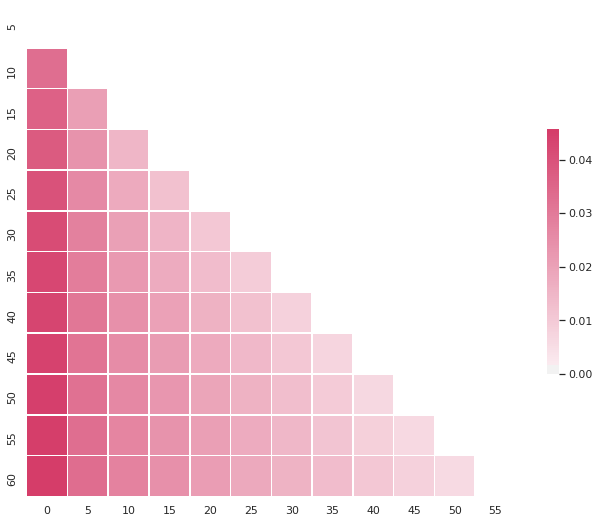

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
mask = np.triu(np.ones_like(df, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(255, 0, as_cmap=True)
ax = sns.heatmap(df, mask=mask,
                 cmap=cmap, vmin=0.0, vmax=df.max().max(), center=0.0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.xaxis.set_label('Shorter temporal window size, sec')
ax.xaxis.set_label('Longer temporal window size, sec')
plt.savefig('TempWind.pdf', format='pdf')

## Box plot

In [0]:
from collections import defaultdict
diff = defaultdict(list)
for idx_big, errs_row in enumerate(errs):
  int_big = intervals[idx_big]
  for idx_small, errs_vals in enumerate(errs_row):
    if len(errs_vals) == 0: continue
    int_small = intervals[idx_small]
    int_diff = int_big - int_small
    diff[intervals.index(int_diff)].extend(errs_vals)

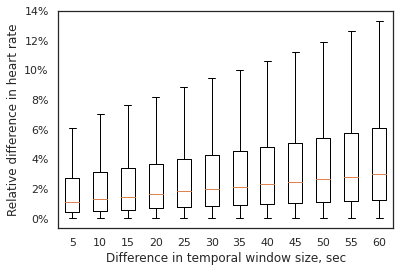

In [12]:
import matplotlib.ticker as mtick
x = [intervals[key] for key in diff.keys()]
y = diff.values()

fig, ax = plt.subplots(1)

ax.set_xticklabels(x)
ax.boxplot(y, showfliers=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0, decimals=0))
ax.set_xlabel('Difference in temporal window size, sec')
ax.set_ylabel('Relative difference in heart rate')
fig.show()
plt.savefig('DiffBox.pdf', format='pdf')